In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv("./train.csv")

In [5]:
data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [9]:
x = data['id']

In [10]:
y = data['has_cactus']

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.15,random_state=42)

In [13]:
xtrain.head()

7613     6d6d4c8122c1111f94805dae99675a5d.jpg
10353    953fec18611f8c7ea18010f4ff0a04d6.jpg
9723     8be2938d2975dde41f84ea7e3264a3da.jpg
16406    efcb21ef9ac16ff619b604f349acff5c.jpg
2414     21bda1944ff8bb9a15b885d01fb30dab.jpg
Name: id, dtype: object

In [24]:
from tqdm import tqdm
xtr_img = []
xte_img = []
for img in tqdm(xtrain):
    img = plt.imread("./train/"+img)
    xtr_img.append(img)
for img2 in tqdm(xtest):
    img2 = plt.imread("./train/"+img2)
    xte_img.append(img2)

100%|████████████████████████████████████████████████████████████████████████████| 2625/2625 [00:00<00:00, 4352.25it/s]


In [29]:
xtr_img = np.array(xtr_img)
xte_img = np.array(xte_img)
print(xtr_img.shape)
print(xte_img.shape)

(14875, 32, 32, 3)
(2625, 32, 32, 3)


In [30]:
xtr_img = xtr_img.astype('float32')
xte_img = xte_img.astype('float32')
xtr_img = xtr_img/255
xte_img = xte_img/255

In [32]:
import keras
from keras.models import Sequential, Model, load_model
from keras.applications.xception import Xception
from keras.layers import Activation ,Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,LearningRateScheduler, ReduceLROnPlateau
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

In [43]:
from keras.layers import *
inputs = Input((32,32,3))
bm = Xception(include_top=False, input_shape=(72,72,3))
x = bm(inputs)
op1 = GlobalMaxPooling2D()(x)
op2 = GlobalAveragePooling2D()(x)
op3 = Flatten()(x)
out = Concatenate(axis=-1)([op1,op2,op3])

out = Dropout(0.5)(out)
out = Dense(512,name="dense512")(out)
out = Dense(256,name="dense256")(out)
out = BatchNormalization()(out)

out = Activation("relu")(out)
out = Dense(1, activation="sigmoid", name="dense1")(out)
model = Model(inputs, out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
flatten_2 

In [47]:
bm.trainable = True

set_trainable = False
for layers in bm.layers:
    layers.trainable = True

In [48]:
model.compile("Adam",loss="binary_crossentropy",metrics=['accuracy'])

In [51]:
from keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 40

fp = "my_nn_weight.hdf5"

chkpoint = ModelCheckpoint(fp, monitor="val_acc", save_best_only=True, verbose=1, mode="max")
lr = ReduceLROnPlateau(monitor="val_loss",factor=0.6,patience=4,min_lr=0,cooldown=0,min_delta=0.0,verbose=1,mode="max")
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=25, verbose=1, mode='max', baseline=None, restore_best_weights=True)

train_dtgen = ImageDataGenerator(rotation_range=45, 
                                 shear_range=0.2,
                                 zoom_range =0.2 ,
                                 vertical_flip=True,
                                 horizontal_flip=True) 
train_dtgen.fit(xtr_img)
history = model.fit_generator(
    train_dtgen.flow(xtr_img, ytrain, batch_size=batch_size),
    steps_per_epoch=xtrain.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(xte_img, ytest),
    callbacks=[lr, chkpoint] 
)

Epoch 1/40
116/116 [==============================] - 14s 121ms/step - loss: 0.0222 - acc: 0.9921 - val_loss: 0.1183 - val_acc: 0.9589

Epoch 00001: val_acc improved from -inf to 0.95886, saving model to my_nn_weight.hdf5
Epoch 2/40
116/116 [==============================] - 14s 119ms/step - loss: 0.0200 - acc: 0.9938 - val_loss: 0.0168 - val_acc: 0.9931

Epoch 00002: val_acc improved from 0.95886 to 0.99314, saving model to my_nn_weight.hdf5
Epoch 3/40
116/116 [==============================] - 14s 121ms/step - loss: 0.0188 - acc: 0.9943 - val_loss: 0.0115 - val_acc: 0.9966

Epoch 00003: val_acc improved from 0.99314 to 0.99657, saving model to my_nn_weight.hdf5
Epoch 4/40
116/116 [==============================] - 14s 118ms/step - loss: 0.0148 - acc: 0.9945 - val_loss: 0.0863 - val_acc: 0.9722

Epoch 00004: val_acc did not improve from 0.99657
Epoch 5/40
116/116 [==============================] - 14s 119ms/step - loss: 0.0105 - acc: 0.9962 - val_loss: 0.0110 - val_acc: 0.9950

Epoch 

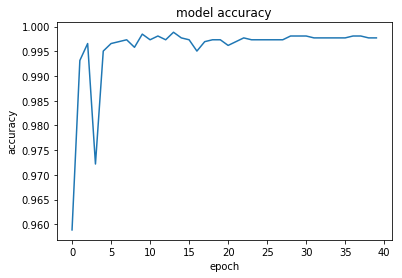

In [53]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

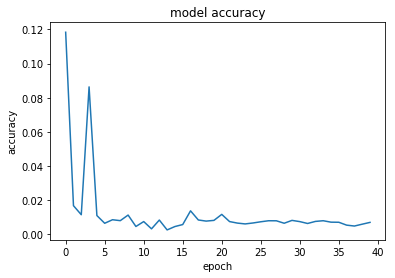

In [55]:
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [57]:
sample = pd.read_csv('./sample_submission.csv')
test = []
for images in tqdm(sample['id']):
    img = plt.imread('./test/' + images)
    test.append(img)

test = np.array(test)
test = test/255

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 245.97it/s]


In [58]:
test_pred = model.predict(test, verbose= 1)

4000/4000 [==============================] - 4s 1ms/step


In [59]:
sample['has_cactus'] = test_pred
sample.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.999970
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.999977
2,001ee6d8564003107853118ab87df407.jpg,0.000006
3,002e175c3c1e060769475f52182583d0.jpg,0.000009
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.999948


In [60]:
sample.to_csv('sub2.csv', index= False)